# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading required packages  & datasets

In [54]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os
import math



#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import RandomizedSearchCV

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_rows', None)

import xgboost as xgb

In [55]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [56]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [57]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [59]:
data.select_dtypes(include=['object']).columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

In [60]:
# convertind date columns to date format

date_cols = [
    "last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8",
    "date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8",
    "date_of_last_rech_data_6", "date_of_last_rech_data_7", "date_of_last_rech_data_8"
]

for col in date_cols:
    data[col] = pd.to_datetime(data[col], format='%m/%d/%Y', errors='coerce')


In [61]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,2014-06-30 00:00:00,2014-07-31 00:00:00.000000256,2014-08-30 23:59:59.999999744,283.134365,278.185912,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
min,0.000000,109.0,0.0,0.0,0.0,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,-2258.709000,-1289.715000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,93.581000,86.714000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,197.484000,191.588000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,370.791000,365.369500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,27731.088000,35145.834000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000
std,20207.115084,0.0,0.0,0.0,0.0,NaN,NaN,NaN,334.213918,344.366927,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502


In [62]:
# checking no of unique values in each column

def no_of_unique_values(df):
    unique_counts = df.nunique() 
    result = {
        "1 unique value": (unique_counts == 1).sum(),
        "2 unique values": (unique_counts == 2).sum(),
        "3 unique values": (unique_counts == 3).sum(),
        ">3 unique values": (unique_counts > 3).sum(),
    }
    return result

no_of_unique_values(data)

{'1 unique value': 13,
 '2 unique values': 7,
 '3 unique values': 0,
 '>3 unique values': 152}

In [63]:
unique_counts = data.nunique()

# Filter column names where unique values are 1 or 2
cols_with_unique_value = unique_counts[unique_counts.isin([1, 2])].index.tolist()

print("Columns with 1 and 2 unique values:", cols_with_unique_value)

Columns with 1 and 2 unique values: ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'churn_probability']


In [64]:
#checking the null values

def null_perc(df):
    return (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)



In [65]:
# chekcing teh columns with null values and only having 1 oe two unique values

null_two_unique=null_perc(data)[null_perc(data) > 0].index.intersection(cols_with_unique_value).tolist()

In [66]:
cols_to_replace_Nan={col: data[col].unique() for col in null_two_unique}
cols_to_replace_Nan

{'night_pck_user_6': array([nan,  0.,  1.]),
 'fb_user_6': array([nan,  1.,  0.]),
 'night_pck_user_7': array([nan,  0.,  1.]),
 'fb_user_7': array([nan,  1.,  0.]),
 'night_pck_user_8': array([nan,  0.,  1.]),
 'fb_user_8': array([nan,  1.,  0.]),
 'std_ic_t2o_mou_8': array([ 0., nan]),
 'std_og_t2c_mou_8': array([ 0., nan]),
 'std_ic_t2o_mou_6': array([ 0., nan]),
 'std_og_t2c_mou_6': array([ 0., nan]),
 'std_ic_t2o_mou_7': array([ 0., nan]),
 'std_og_t2c_mou_7': array([ 0., nan]),
 'last_date_of_month_8': <DatetimeArray>
 ['2014-08-31 00:00:00', 'NaT']
 Length: 2, dtype: datetime64[ns],
 'loc_ic_t2o_mou': array([ 0., nan]),
 'std_og_t2o_mou': array([ 0., nan]),
 'loc_og_t2o_mou': array([ 0., nan]),
 'last_date_of_month_7': <DatetimeArray>
 ['2014-07-31 00:00:00', 'NaT']
 Length: 2, dtype: datetime64[ns]}

In [67]:
cols_to_replace_Nan= [
    'night_pck_user_6', 'fb_user_6', 'night_pck_user_7', 'fb_user_7',
    'night_pck_user_8', 'fb_user_8', 'std_ic_t2o_mou_8', 'std_og_t2c_mou_8',
    'std_ic_t2o_mou_6', 'std_og_t2c_mou_6', 'std_ic_t2o_mou_7', 'std_og_t2c_mou_7',
    'loc_ic_t2o_mou', 'std_og_t2o_mou', 'loc_og_t2o_mou'
]

In [68]:
# Replace NaN values with 0

data[cols_to_replace_Nan] = data[cols_to_replace_Nan].fillna(0)

In [69]:
# checking again null values 

null_perc(data)[null_perc(data) > 0]

arpu_3g_6                   74.902499
count_rech_3g_6             74.902499
date_of_last_rech_data_6    74.902499
count_rech_2g_6             74.902499
total_rech_data_6           74.902499
arpu_2g_6                   74.902499
max_rech_data_6             74.902499
av_rech_amt_data_6          74.902499
date_of_last_rech_data_7    74.478207
total_rech_data_7           74.478207
arpu_3g_7                   74.478207
count_rech_2g_7             74.478207
arpu_2g_7                   74.478207
av_rech_amt_data_7          74.478207
max_rech_data_7             74.478207
count_rech_3g_7             74.478207
av_rech_amt_data_8          73.689624
max_rech_data_8             73.689624
date_of_last_rech_data_8    73.689624
arpu_3g_8                   73.689624
total_rech_data_8           73.689624
arpu_2g_8                   73.689624
count_rech_3g_8             73.689624
count_rech_2g_8             73.689624
std_og_t2t_mou_8             5.290076
std_og_t2m_mou_8             5.290076
loc_ic_mou_8

In [70]:
# Dropping columns with more than 70 % of missing values

data.drop(null_perc(data)[null_perc(data) > 70].index, axis=1, inplace=True)

In [71]:
# checking null values again

len(null_perc(data)[null_perc(data) > 0])

86

In [72]:
# replacing non date columns with median

num_cols = data.select_dtypes(include=['float64', 'int64']).columns  
data[num_cols] = data[num_cols].fillna(data[num_cols].median())


In [73]:
# replacing date columns with mode

date_cols = data.select_dtypes(include=['datetime64']).columns  
for col in date_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)  


In [74]:
#again checking null values

null_perc(data)[null_perc(data) > 0]


Series([], dtype: float64)

In [75]:
#  dropping teh colums with one_unique value

data.drop(columns=[col for col in data.columns if data[col].nunique() == 1], inplace=True)

In [76]:
no_of_unique_values(data)

{'1 unique value': 0,
 '2 unique values': 7,
 '3 unique values': 0,
 '>3 unique values': 128}

In [77]:
# dropping date columns


data.drop(columns=[col for col in data.columns if np.issubdtype(data[col].dtype, np.datetime64)], inplace=True)


##  2. Exploratory Data Analysis


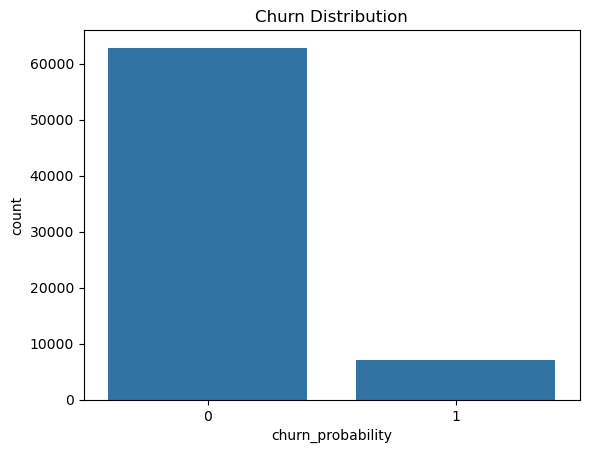

In [79]:
# checking teh churn data distribution

sns.countplot(x=data['churn_probability'])
plt.title("Churn Distribution")
plt.show()

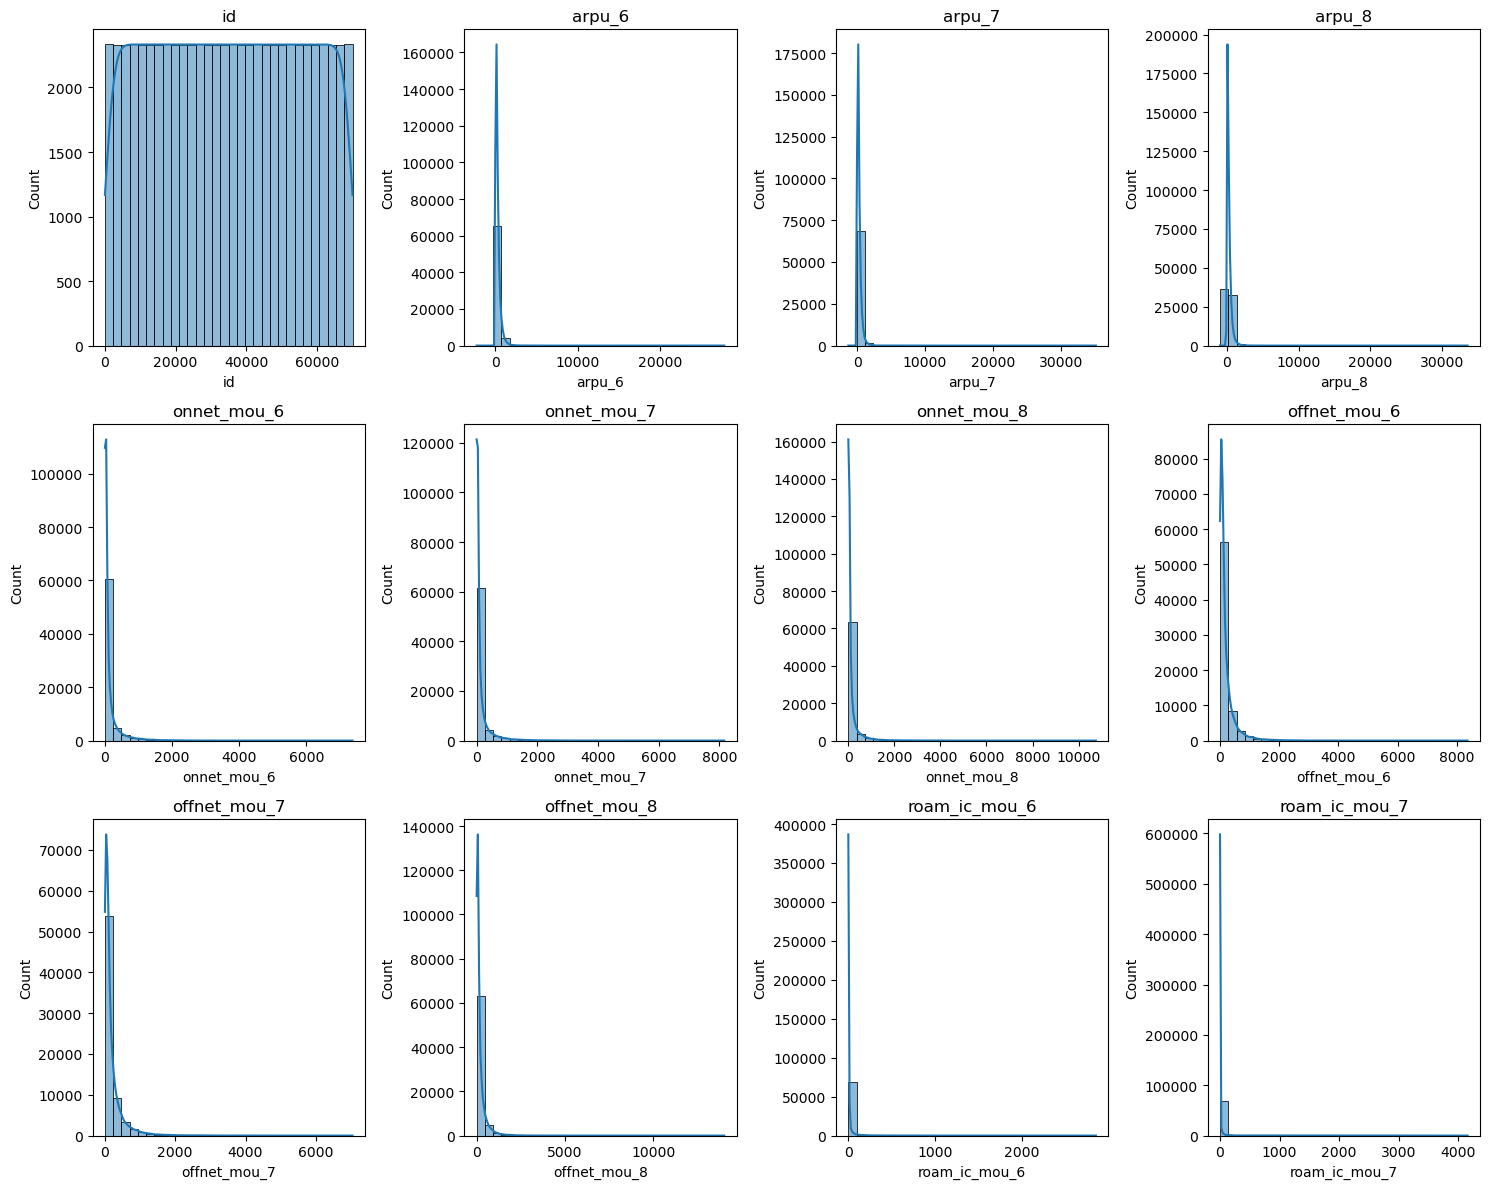

In [80]:
def plot_histograms(data, cols_per_row=4, rows=3):
    total_cols = len(num_cols)
    total_plots = min(total_cols, cols_per_row * rows)
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(num_cols[:total_plots]):  # Limit to first few
        sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()


num_cols = data.select_dtypes(include=['float64', 'int64']).columns

plot_histograms(data)

In [81]:
# function to check putliers

def find_outliers_iqr(data, columns):
    outlier_counts = {}

    for col in columns:
        Q1 = data[col].quantile(0.25)  
        Q3 = data[col].quantile(0.75) 
        IQR = Q3 - Q1  

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        outlier_counts[col] = outliers

    return {col: count for col, count in outlier_counts.items() if count > 0}  

num_cols = data.select_dtypes(include=['float64', 'int64']).columns  


outliers_dict = find_outliers_iqr(data, num_cols)


print(outliers_dict)

{'arpu_6': 4055, 'arpu_7': 4018, 'arpu_8': 3835, 'onnet_mou_6': 8559, 'onnet_mou_7': 8820, 'onnet_mou_8': 8898, 'offnet_mou_6': 6251, 'offnet_mou_7': 6496, 'offnet_mou_8': 6580, 'roam_ic_mou_6': 13575, 'roam_ic_mou_7': 10373, 'roam_ic_mou_8': 10103, 'roam_og_mou_6': 13651, 'roam_og_mou_7': 10369, 'roam_og_mou_8': 10012, 'loc_og_t2t_mou_6': 7615, 'loc_og_t2t_mou_7': 7573, 'loc_og_t2t_mou_8': 7618, 'loc_og_t2m_mou_6': 6161, 'loc_og_t2m_mou_7': 6137, 'loc_og_t2m_mou_8': 6207, 'loc_og_t2f_mou_6': 11305, 'loc_og_t2f_mou_7': 11242, 'loc_og_t2f_mou_8': 11381, 'loc_og_t2c_mou_6': 13288, 'loc_og_t2c_mou_7': 14223, 'loc_og_t2c_mou_8': 14858, 'loc_og_mou_6': 6145, 'loc_og_mou_7': 6214, 'loc_og_mou_8': 6188, 'std_og_t2t_mou_6': 12773, 'std_og_t2t_mou_7': 12783, 'std_og_t2t_mou_8': 13002, 'std_og_t2m_mou_6': 10892, 'std_og_t2m_mou_7': 10975, 'std_og_t2m_mou_8': 11302, 'std_og_t2f_mou_6': 8151, 'std_og_t2f_mou_7': 7553, 'std_og_t2f_mou_8': 7519, 'std_og_mou_6': 10260, 'std_og_mou_7': 10458, 'std_og_

In [82]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
outlier_percentage = (outliers / data.shape[0]) * 100


outlier_percentage[outlier_percentage > 10].sort_values(ascending=False)

fb_user_8            23.424620
fb_user_7            23.213189
fb_user_6            22.997471
vol_2g_mb_8          22.744611
vol_2g_mb_7          22.543179
vol_2g_mb_6          22.267461
ic_others_6          22.208889
ic_others_8          21.766025
loc_og_t2c_mou_8     21.226018
spl_ic_mou_6         20.888870
std_ic_t2f_mou_7     20.576008
std_ic_t2f_mou_8     20.537436
std_ic_t2f_mou_6     20.510293
loc_og_t2c_mou_7     20.318862
roam_og_mou_6        19.501707
roam_ic_mou_6        19.393134
ic_others_7          19.374562
loc_og_t2c_mou_6     18.983128
std_og_t2t_mou_8     18.574551
std_og_t2t_mou_7     18.261689
std_og_t2t_mou_6     18.247404
std_ic_t2t_mou_8     17.103101
og_others_6          16.954528
std_ic_t2t_mou_6     16.783097
aug_vbc_3g           16.644523
std_ic_t2t_mou_7     16.594523
spl_og_mou_6         16.463092
loc_og_t2f_mou_8     16.258804
isd_ic_mou_7         16.201660
loc_og_t2f_mou_6     16.150231
std_og_t2m_mou_8     16.145945
jul_vbc_3g           16.074515
loc_og_t

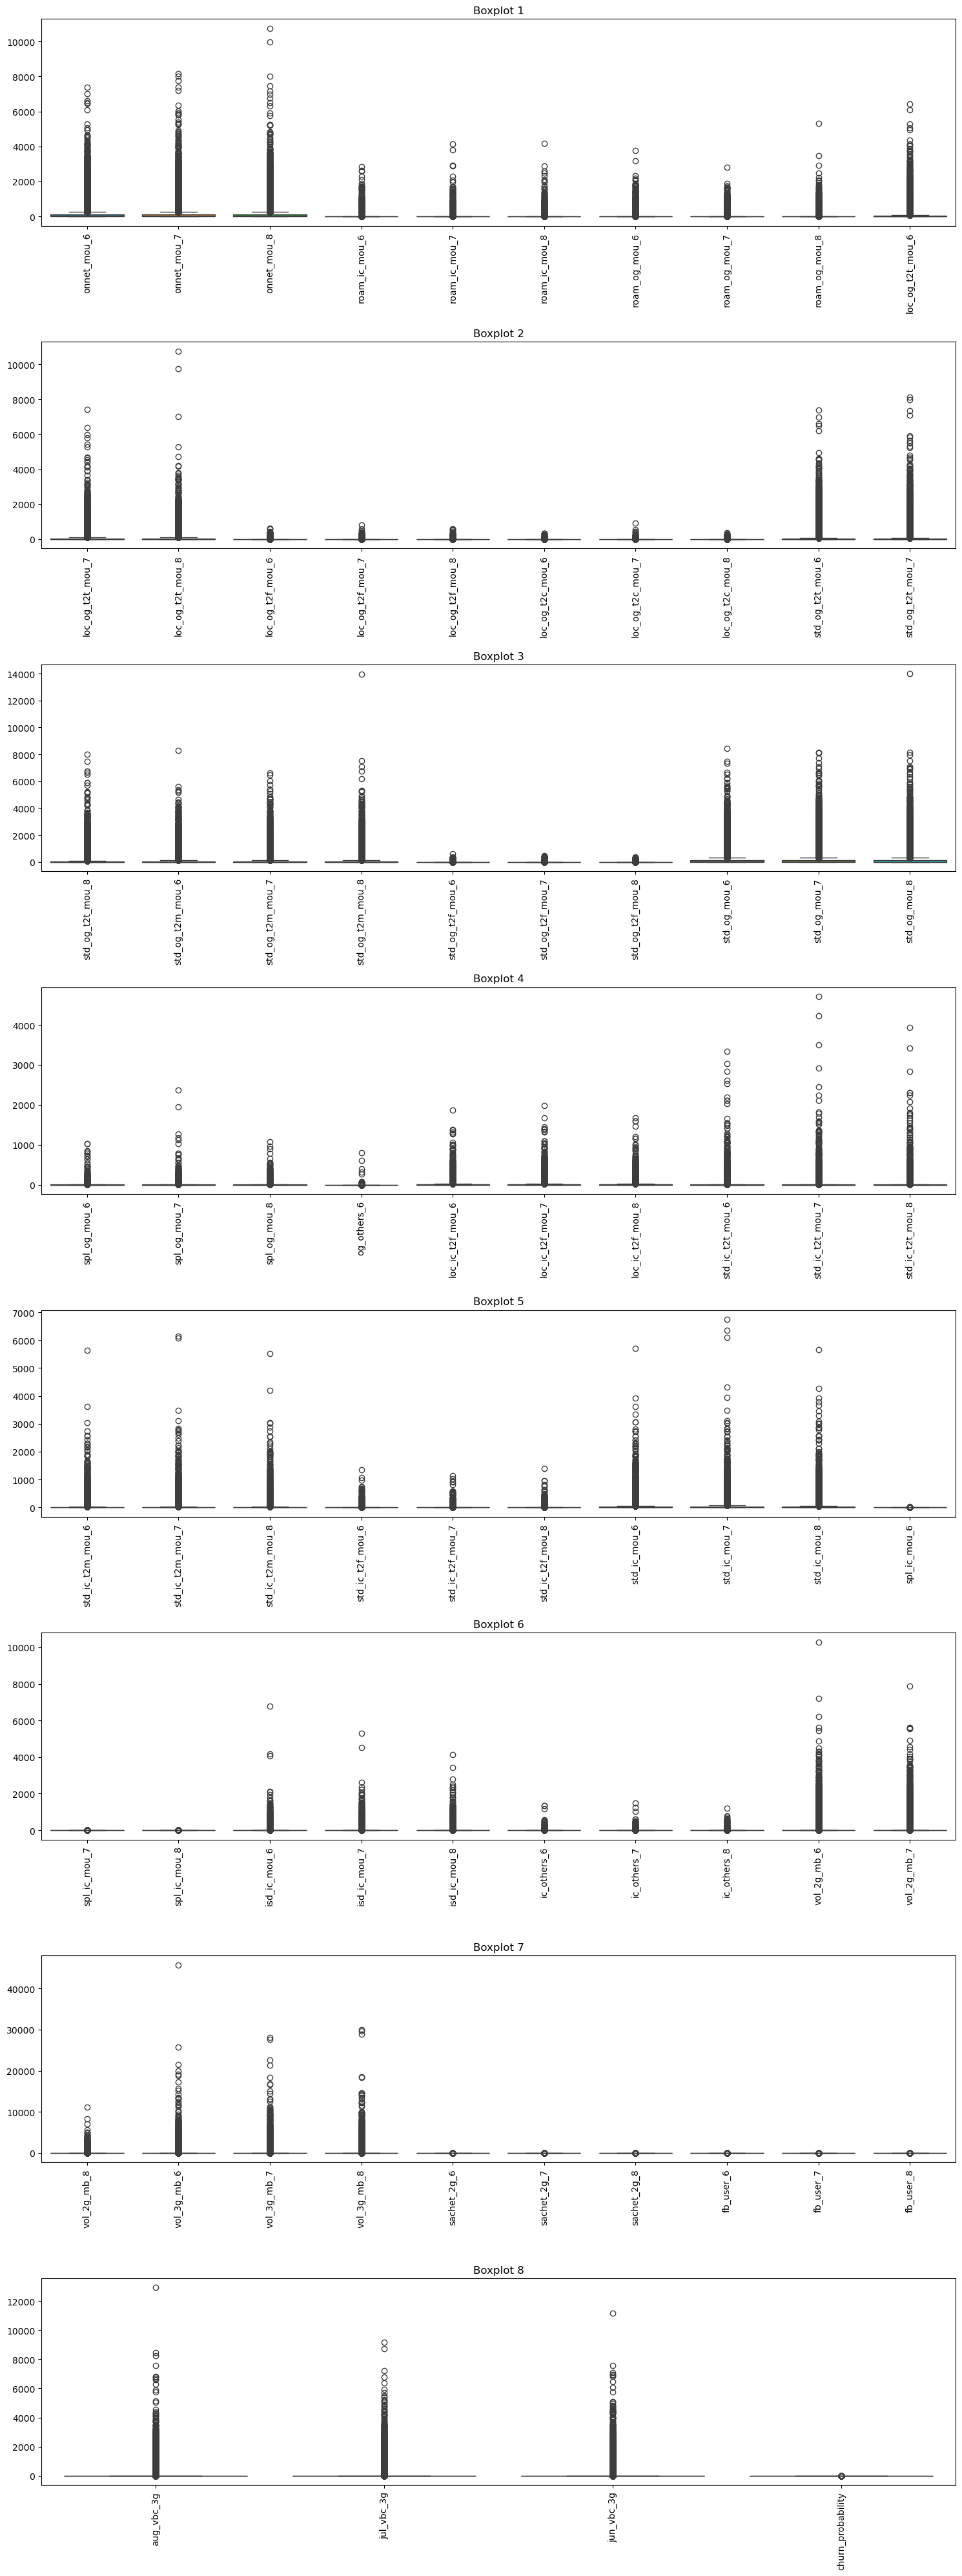

In [83]:
def plot_boxplots(data, outlier_threshold=10, cols_per_row=10):
    # Compute Outliers
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    outlier_percentage = (outliers / data.shape[0]) * 100

    # Select columns with > 10% outliers
    high_outlier_cols = outlier_percentage[outlier_percentage > outlier_threshold].index.tolist()

    if not high_outlier_cols:
        print("No columns with outlier percentage greater than the threshold.")
        return

    # Split into multiple rows (10 columns per row)
    num_cols = len(high_outlier_cols)
    num_rows = math.ceil(num_cols / cols_per_row)

    # Plot boxplots
    fig, axes = plt.subplots(num_rows, 1, figsize=(cols_per_row * 1.5, num_rows * 5), squeeze=False)

    for i in range(num_rows):
        start_idx = i * cols_per_row
        end_idx = min(start_idx + cols_per_row, num_cols)
        selected_cols = high_outlier_cols[start_idx:end_idx]

        sns.boxplot(data=data[selected_cols], orient="v", ax=axes[i, 0])
        axes[i, 0].set_xticklabels(selected_cols, rotation=90)
        axes[i, 0].set_title(f"Boxplot {i+1}")

    plt.tight_layout()
    plt.show()


plot_boxplots(data, outlier_threshold=10, cols_per_row=10)

## 3 Create X, y and then Train test split

In [85]:

X = data.drop(columns=['churn_probability'])  # Drop the target column
y = data['churn_probability']  # Target variable


In [86]:
# Splitting the data (80% train, 20% test)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

### 4 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [88]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

# 5. Feature engineering and selection

### 5.1 Create a basic Random Forest Model  and get 25 important features

In [91]:
# Train a basic Random Forest Mode


rf_model=RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-100)

rf_model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-100, random_state=42)

In [92]:
# predict on train data

y_pred_train=rf_model.predict(X_train)


# Predict on test data
y_pred_test = rf_model.predict(X_test)


# Check accuracy (just for reference)

metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for metric_name, metric_func in metrics.items():
    train_score = metric_func(y_train, y_pred_train)
    test_score = metric_func(y_test, y_pred_test)
    print(f"{metric_name} - Train: {train_score:.4f}, Test: {test_score:.4f}")

# Confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("\nTrain Confusion Matrix:")
print(conf_matrix_train)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

Accuracy - Train: 0.9999, Test: 0.9435
Precision - Train: 1.0000, Test: 0.7840
Recall - Train: 0.9993, Test: 0.6125

Train Confusion Matrix:
[[50289     0]
 [    4  5706]]

Test Confusion Matrix:
[[12338   240]
 [  551   871]]


total_ic_mou_8        0.103213
total_og_mou_8        0.058113
arpu_8                0.036053
total_rech_amt_8      0.031683
loc_ic_mou_8          0.025992
last_day_rch_amt_8    0.025951
total_ic_mou_7        0.025524
max_rech_amt_8        0.023983
loc_ic_t2m_mou_8      0.022239
loc_ic_t2t_mou_8      0.017330
loc_og_mou_8          0.016230
loc_og_t2m_mou_8      0.015796
offnet_mou_8          0.015722
loc_ic_t2f_mou_8      0.015685
total_og_mou_7        0.015473
roam_og_mou_8         0.013933
std_ic_t2m_mou_8      0.013619
arpu_7                0.012877
total_rech_num_8      0.012540
aon                   0.012126
roam_ic_mou_8         0.011569
std_og_mou_8          0.011301
loc_og_t2t_mou_8      0.011127
id                    0.010701
std_og_t2m_mou_8      0.010653
dtype: float64


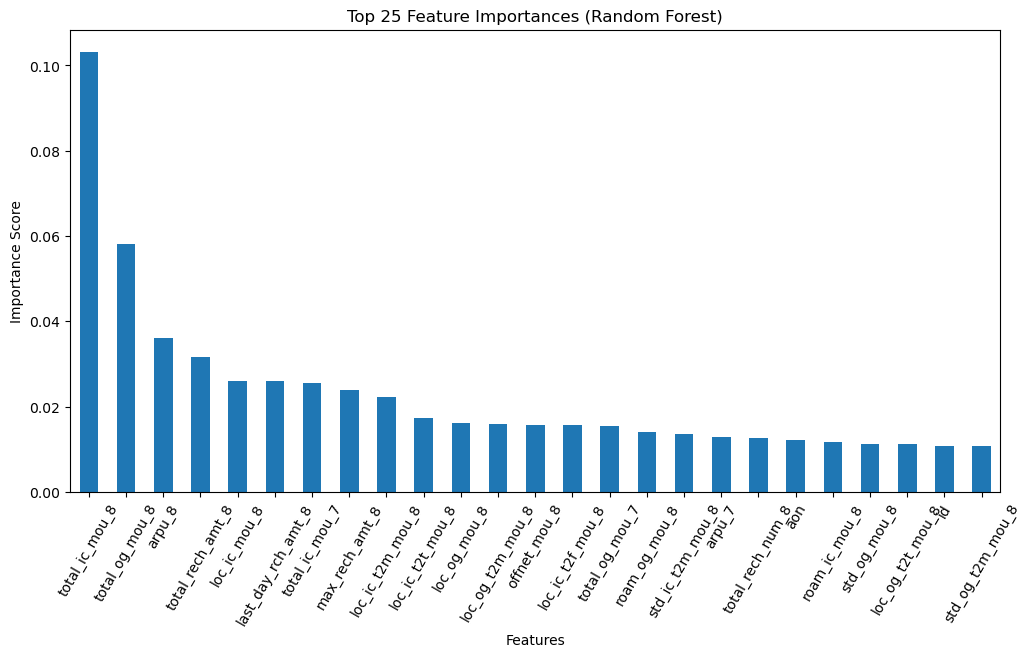

In [93]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print(feature_importance[:25])

# Plot top 25 important features

plt.figure(figsize=(12, 6))
feature_importance[:25].plot(kind='bar')
plt.title("Top 25 Feature Importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=60)
plt.show()

### 5.2 Use RandomizedSearchCV to finetune Random forest model for better feature selection

In [95]:
parameters = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [10, 20, 30],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "max_features": ["sqrt", "log2"],  # Number of features to consider
    "bootstrap": [True, False],  # Whether to use bootstrap sampling
}

In [96]:
rf=RandomForestClassifier(random_state=42,n_jobs=-1)

rf_random=RandomizedSearchCV(estimator=rf,
                            param_distributions=parameters
                            ,n_iter=10, 
                            cv=3,  
                            verbose=2,
                            random_state=42,
                            n_jobs=-1,)

rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [97]:
# Get the best model
best_rf = rf_random.best_estimator_

# predict on train data

y_pred_train=best_rf.predict(X_train)


# Predict on test data
y_pred_test =best_rf.predict(X_test)


# Check accuracy (just for reference)

metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for metric_name, metric_func in metrics.items():
    train_score = metric_func(y_train, y_pred_train)
    test_score = metric_func(y_test, y_pred_test)
    print(f"{metric_name} - Train: {train_score:.4f}, Test: {test_score:.4f}")

# Confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("\nTrain Confusion Matrix:")
print(conf_matrix_train)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

Accuracy - Train: 0.9637, Test: 0.9434
Precision - Train: 0.9120, Test: 0.7807
Recall - Train: 0.7133, Test: 0.6160

Train Confusion Matrix:
[[49896   393]
 [ 1637  4073]]

Test Confusion Matrix:
[[12332   246]
 [  546   876]]


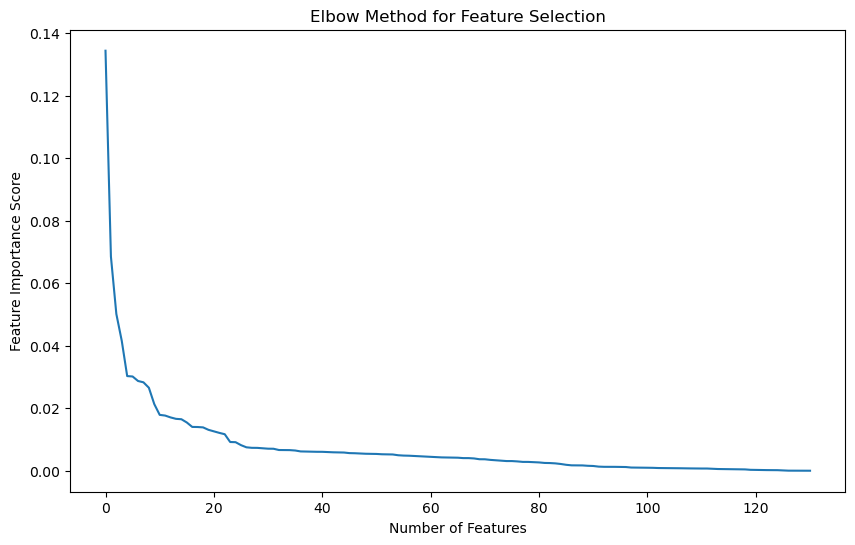

In [98]:

feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": best_rf.feature_importances_}
)


feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

feature_importance.reset_index(drop=True, inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(range(len(feature_importance)), feature_importance["Importance"])
plt.xlabel("Number of Features")
plt.ylabel("Feature Importance Score")
plt.title("Elbow Method for Feature Selection")

plt.show()

### Based on the ebow curve its seen that  below 30 features contributes the most important features 

total_ic_mou_8        0.134375
total_og_mou_8        0.068514
arpu_8                0.050156
total_rech_amt_8      0.041550
total_ic_mou_7        0.030284
loc_ic_mou_8          0.030153
last_day_rch_amt_8    0.028714
max_rech_amt_8        0.028289
loc_ic_t2m_mou_8      0.026556
loc_og_mou_8          0.021317
roam_og_mou_8         0.017874
loc_og_t2m_mou_8      0.017653
offnet_mou_8          0.017059
loc_ic_t2t_mou_8      0.016603
total_og_mou_7        0.016479
loc_og_t2t_mou_8      0.015441
std_ic_t2m_mou_8      0.014019
std_og_mou_8          0.013987
loc_ic_t2f_mou_8      0.013871
roam_ic_mou_8         0.013088
total_rech_num_8      0.012598
std_og_t2m_mou_8      0.012113
arpu_7                0.011685
onnet_mou_8           0.009192
aon                   0.009137
std_ic_mou_8          0.008190
loc_ic_mou_7          0.007495
id                    0.007330
loc_ic_t2m_mou_7      0.007316
total_ic_mou_6        0.007180
dtype: float64


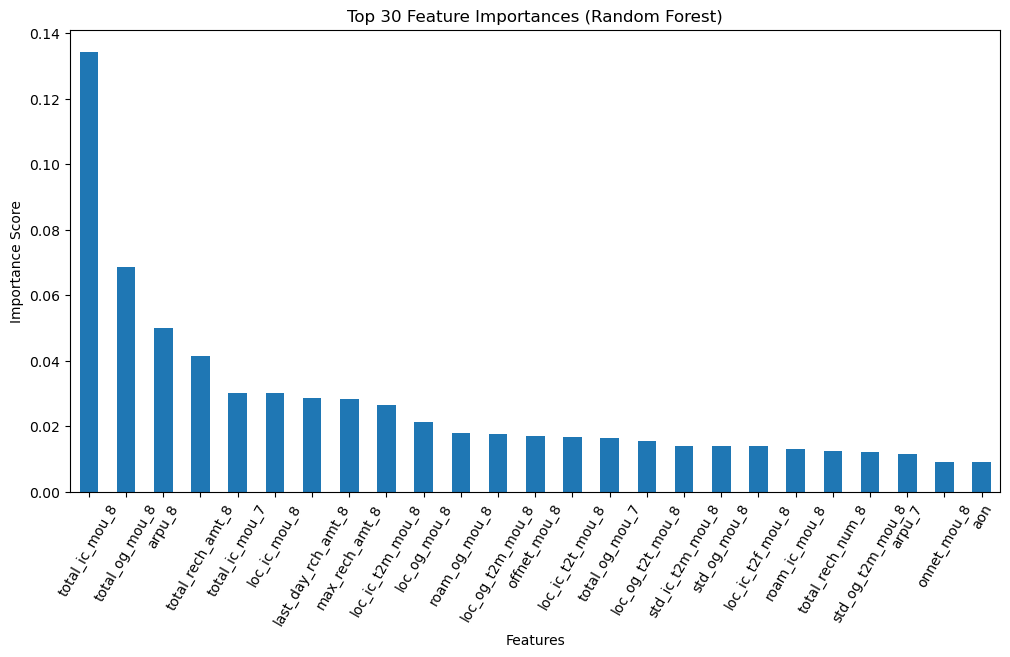

In [100]:
feature_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print(feature_importance[:30])



plt.figure(figsize=(12, 6))
feature_importance[:25].plot(kind='bar')
plt.title("Top 30 Feature Importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=60)
plt.show()

###  creating new X_train and X_test based on teh 30 selected features

In [118]:


# Select the top 30 features
selected_features = feature_importance.index[:30].tolist() #feature_importance["Feature"].iloc[:30].tolist()

# Create new X_train and X_test
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected 30 Features: {selected_features}")

Selected 30 Features: ['total_ic_mou_8', 'total_og_mou_8', 'arpu_8', 'total_rech_amt_8', 'total_ic_mou_7', 'loc_ic_mou_8', 'last_day_rch_amt_8', 'max_rech_amt_8', 'loc_ic_t2m_mou_8', 'loc_og_mou_8', 'roam_og_mou_8', 'loc_og_t2m_mou_8', 'offnet_mou_8', 'loc_ic_t2t_mou_8', 'total_og_mou_7', 'loc_og_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_og_mou_8', 'loc_ic_t2f_mou_8', 'roam_ic_mou_8', 'total_rech_num_8', 'std_og_t2m_mou_8', 'arpu_7', 'onnet_mou_8', 'aon', 'std_ic_mou_8', 'loc_ic_mou_7', 'id', 'loc_ic_t2m_mou_7', 'total_ic_mou_6']


## 5.3 Train Xgboost on selected features for final optimized model

In [120]:

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",  
    eval_metric="logloss",       
    use_label_encoder=False,      
    random_state=42
)


xgb_model.fit(X_train_selected, y_train)

# predict on train data

y_pred_train=xgb_model.predict(X_train_selected)


# Predict on test data
y_pred_test =xgb_model.predict(X_test_selected)


# Check accuracy (just for reference)

metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for metric_name, metric_func in metrics.items():
    train_score = metric_func(y_train, y_pred_train)
    test_score = metric_func(y_test, y_pred_test)
    print(f"{metric_name} - Train: {train_score:.4f}, Test: {test_score:.4f}")

# Confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("\nTrain Confusion Matrix:")
print(conf_matrix_train)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

Accuracy - Train: 0.9689, Test: 0.9400
Precision - Train: 0.8690, Test: 0.7351
Recall - Train: 0.8187, Test: 0.6399

Train Confusion Matrix:
[[49584   705]
 [ 1035  4675]]

Test Confusion Matrix:
[[12250   328]
 [  512   910]]


# 7. Creating submission file
For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [122]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [124]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [130]:
X_unseen = unseen[X_train_selected.columns]
X_unseen.shape

(30000, 30)

In [134]:
# Assume X_unseen is your new data
# X_unseen need to be process before it can be fed to model

# Predict using XGBoost
#y_unseen_pred = xgb_model.predict(X_unseen)
#y_unseen_pred.shape